# Tacotron Synthesis Notebook **(WIP)**

Last edit: December 14th, 2020, 7:54 PM

This is the notebook for synthesizing audio using Tacotron.




If you're looking for the Glow-TTS notebooks, I haven't made them yet. I'll probably make the synthesis notebook sometime soon, but when/if I ever get it working again, I'll also put the training notebook here.

Tacotron2 by NVIDIA

https://github.com/NVIDIA/tacotron2

Notebook plagarized from Cookie's Notebook (sorry Cookie)

First, go up to "Files", and click "Save copy to Drive", and go to the copy.

# If you used the training notebook to make a model, follow these steps before using

Go to your Google Drive, (https://drive.google.com/drive/my-drive), go into the folder that says "colab", go into "outdir", and right click on the .tar file with your model's name.
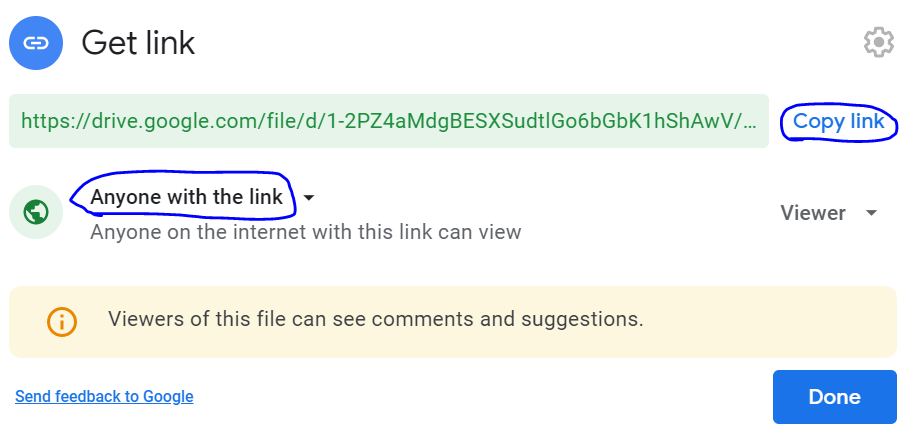
Click on "get shareable link", change "Restricted" to "anyone with the link", then copy the link!

# Check GPU

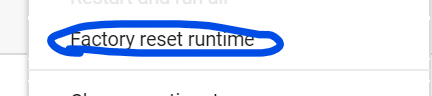

This time, checking the GPU is important. If the GPU comes up as "K80", it will not work; the notebook won't output any sound. If this happens, go up to runtime, and click "Factory reset runtime"

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-3e3ff74c-8e70-80b7-dd0a-1c1fa5c552f8)


Waveglow is the vocoder that we'll be using (the vocoder looks at the generated spectrogram, and converts it to sound)

In [ ]:
#@title Install Tacotron and Waveglow (click to see code)
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext
!pip install gdown
git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 2fd4e63
  !pip install -q librosa unidecode

import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
import gdown
d = 'https://drive.google.com/uc?id='

TensorFlow 1.x selected.
Previous HEAD position was 5bc2a53 README.md: reporting correct number after finding bug in inference time code
HEAD is now at 2fd4e63 README.md: update waveglow speed and published models url
     |████████████████████████████████| 241 kB 5.3 MB/s 


# Select Tacotron model

Copy and paste the link to your model, but remove the "https://drive.google.com/file/d/" and "/view?usp=sharing", so it's just the code part. If you don't have a model, I've included some models that you can use (I'll add more in the future)

In [ ]:
force_download_TT2 = True
tacotron2_pretrained_model = 'MLPTTS'
if not exists(tacotron2_pretrained_model) or force_download_TT2:
                   # ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ PUT MODEL HERE
  gdown.download(d+r'#########', tacotron2_pretrained_model, quiet=False); print("Tacotron2 Model Downloaded")
                   # ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ PUT MODEL HERE

waveglow_pretrained_model = 'waveglow.pt'
if not exists(waveglow_pretrained_model):
  gdown.download(d+r'######', waveglow_pretrained_model, quiet=False); print("WaveGlow Model Downloaded")

Downloading...
From: https://drive.google.com/uc?id=1-LsaVIr6xvOPQ2ubjbIXI4lKoL_QmVHJ
To: /content/MLPTTS
338MB [00:02, 153MB/s]


Tacotron2 Model Downloaded


Downloading...
From: https://drive.google.com/uc?id=1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF
To: /content/waveglow.pt
676MB [00:04, 150MB/s]


WaveGlow Model Downloaded


### List of models

This list will be updated as I make/find new models to add

*Models that I (Adam is cool and stuff) made*

* Freddie Mercury: 1D5nvE_Cna4EYJllrYBEGrenrMGktUe3e (English)
* John Lennon: 1--0k34jIEWfAbaE2QWjECYL22RuzCZpD (kinda English)
* Paul McCartney: 1dCXvHrUX5YaMPoJVek_EaJH8XVpEhvCS (kinda English)
* George Harrison: 1AljUxLKb9eql64XUqJS9nxXwjrrDbMe1 (not English)
* Ringo Starr: 1YVtpA2GNqTtGaEhZmH2m7PlkE0VyMrRD (kinda English)
* Bill Cipher: 1-4xGJ-pr6Mr9cw2pW34-jNou8ryAidQF (English)

*Models that other people made*

* HAL 9000: 12r9fXK42WexER1pS1q30CEXH02i5X3X_
* Tucker Carlson: 1VedzecAnPtD_8maYdt1k0SrUQ3lFGmwW
* Leafyishere: 1jIwBlRhwwUmOh7Dtwe5tcjHVwGtsSvBG

*MLP characters*

* Twilight Sparkle: 1wQo4D_MANiDQk4POcxGBk_v88LYQdaci
* Rainbow Dash: 1--57T0M5ORzEcqaUN4DuqtejOIqnd4uS
* Rarity: 1RC8Qx7nY6D5olnhjo3rdAuZnWx6T67bE
* Pinkie Pie: 1jlWt_7njh6m_AS5B84JFz_wX6xPJzctf
* Fluttershy: 1Z-qWMc7Ozachphlbal718IZH2K19r7SC
* Applejacks: 1Ltpm4SiU2yhJAMvyuEZfzr4mteqZowhc



# Getting the AI ready

In [ ]:
#@title Initialize Tacotron and Waveglow
%matplotlib inline
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

graph_width = 900
graph_height = 360
def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
    %matplotlib inline
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom',
                       interpolation='none', cmap='inferno')
    fig.canvas.draw()
    plt.show()

!gdown --id '1IUxCkgRNsoDCLtMZxYXmIePAKgh0m-aZ'
thisdict = {}
for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
    thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()
def ARPA(text):
    out = ''
    for word_ in text.split(" "):
        word=word_; end_chars = ''
        while any(elem in word for elem in r"!?,.;") and len(word) > 1:
            if word[-1] == '!': end_chars = '!' + end_chars; word = word[:-1]
            if word[-1] == '?': end_chars = '?' + end_chars; word = word[:-1]
            if word[-1] == ',': end_chars = ',' + end_chars; word = word[:-1]
            if word[-1] == '.': end_chars = '.' + end_chars; word = word[:-1]
            if word[-1] == ';': end_chars = ';' + end_chars; word = word[:-1]
            else: break
        try: word_arpa = thisdict[word.upper()]
        except: word_arpa = ''
        if len(word_arpa)!=0: word = "{" + str(word_arpa) + "}"
        out = (out + " " + word + end_chars).strip()
    if out[-1] != ";": out = out + ";"
    return out

#torch.set_grad_enabled(False)

# initialize Tacotron2 with the pretrained model
hparams = create_hparams()

Downloading...
From: https://drive.google.com/uc?id=1IUxCkgRNsoDCLtMZxYXmIePAKgh0m-aZ
To: /content/merged.dict.txt
7.94MB [00:00, 124MB/s]
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
# Load Tacotron2 (run this cell every time you change the model)
hparams.sampling_rate = 22050 # Don't change this
hparams.max_decoder_steps = 1000 # How long the audio will be before it cuts off (1000 is about 11 seconds)
hparams.gate_threshold = 0.1 # Model must be 90% sure the clip is over before ending generation (the higher this number is, the more likely that the AI will keep generating until it reaches the Max Decoder Steps)
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval().half()

In [ ]:
# Load WaveGlow
waveglow = torch.load(waveglow_pretrained_model)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

#The actual synthesis part

This is where you actually synthesize the audio! You can input whatever you want. I put in the lyrics to All Star.

Namaste Hajur lai kasto cha.
{N AA1 M AA0 S T EY2} Hajur {L AY1} kasto {CH AA1}.;
Warning! Reached max decoder steps


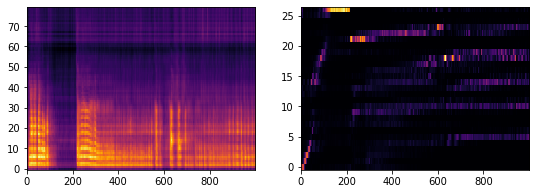

In [ ]:
text = """
Namaste Hajur lai kasto cha.
"""
sigma = 0.8
denoise_strength = 0.324
raw_input = False # disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing

for i in text.split("\n"):
    if len(i) < 1: continue;
    print(i)
    if raw_input:
        if i[-1] != ";": i=i+";"
    else: i = ARPA(i)
    print(i)
    with torch.no_grad(): # save VRAM by not including gradients
        sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                alignments.float().data.cpu().numpy()[0].T))
        audio = waveglow.infer(mel_outputs_postnet, sigma=sigma); print(""); ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))

If the generated audio doesn't come out that good, try generating it again.

And, that's it! If the synthesis didn't work, leave a comment on my video, and I'll try to reply!
